In [1]:
import requests
#Go to this link
#http://www.strava.com/oauth/authorize?client_id=131123&redirect_uri=http://localhost/&response_type=code&scope=activity:read_all
#Accept and copy code from url

# Replace these with your actual values
client_id = 'XXXXX'
client_secret = 'XXXXX'  # You get this from your Strava app settings
code = 'XXXXX'  # The code you get from the redirect after user authorization

# Token endpoint
token_url = 'https://www.strava.com/oauth/token'

# Prepare the data to be sent to Strava to get the access token
payload = {
    'client_id': client_id,
    'client_secret': client_secret,
    'code': code,
    'grant_type': 'authorization_code'
}

# Make a POST request to get the access token
response = requests.post(token_url, data=payload)

# Check if the request was successful
if response.status_code == 200:
    # Extract the access token from the response
    access_token = response.json()['access_token']
    print(f"Access Token: {access_token}")
else:
    print(f"Error: {response.json()}")

Access Token: 868cb5b9d7ab63f42f6f4c60ec76e7e5a9345b51


In [2]:
import requests
import pandas as pd
import requests
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import json

# Base URL for Strava API
base_url = 'https://www.strava.com/api/v3'

# Endpoint to get activities
activities_url = f'{base_url}/athlete/activities'

# Parameters for pagination
page = 1
per_page = 30  # You can adjust this as needed

activities = []

# Define the bounding box for the region of interest
southwest_lat, southwest_lng = -2.9265042629096008, -79.04913722725871
northeast_lat, northeast_lng = -2.8818099922468314, -78.96429867032286
while True:
    # Make the GET request
    response = requests.get(
        activities_url,
        headers={
            'Authorization': f'Bearer {access_token}'
        },
        params={
            'page': page,
            'per_page': per_page
        }
    )

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        if not data:
            break  # No more data to fetch
        activities.extend(data)
        page += 1
    else:
        print('Error:', response.json())
        break

running_activities=[activity for activity in activities if activity['type'] == 'Run']
def decode_polyline(polyline_str):
    index = 0
    lat = 0
    lng = 0
    coordinates = []

    while index < len(polyline_str):
        b = 0
        shift = 0
        result = 0
        while True:
            b = ord(polyline_str[index]) - 63
            index += 1
            result |= (b & 0x1f) << shift
            shift += 5
            if not b & 0x20:
                break
        dlat = ~(result >> 1) if result & 1 else result >> 1
        lat += dlat
        shift = 0
        result = 0
        while True:
            b = ord(polyline_str[index]) - 63
            index += 1
            result |= (b & 0x1f) << shift
            shift += 5
            if not b & 0x20:
                break
        dlng = ~(result >> 1) if result & 1 else result >> 1
        lng += dlng
        coordinates.append((lat / 1e5, lng / 1e5))
    return coordinates

#Filter by area in map
def filter_activities_by_bbox(running_activities, bbox):
    filtered_activities = []
    for activity in running_activities:
        map_polyline = activity.get('map', {}).get('summary_polyline', '')
        coordinates = decode_polyline(map_polyline)
        if any(southwest_lat <= lat <= northeast_lat and southwest_lng <= lng <= northeast_lng for lat, lng in coordinates):
            filtered_activities.extend(coordinates)
    return filtered_activities


# Create and display heat map
def create_heat_map(coordinates):
    folium_map = folium.Map(location=[sum(lat for lat, _ in coordinates) / len(coordinates),
                                      sum(lng for _, lng in coordinates) / len(coordinates)],
                           zoom_start=13)
    HeatMap(coordinates).add_to(folium_map)
    HeatMap(coordinates, radius=5, blur=1).add_to(folium_map)
    # Display the map inline in Jupyter Notebook
    display(folium_map)

all_coordinates = []

for activity in running_activities:
    map_polyline = activity.get('map', {}).get('summary_polyline', '')
    coordinates = decode_polyline(map_polyline)
    all_coordinates.extend(coordinates)

filtered_coordinates = filter_activities_by_bbox(running_activities, (southwest_lat, southwest_lng, northeast_lat, northeast_lng))
create_heat_map(filtered_coordinates)

### Participation by activity type

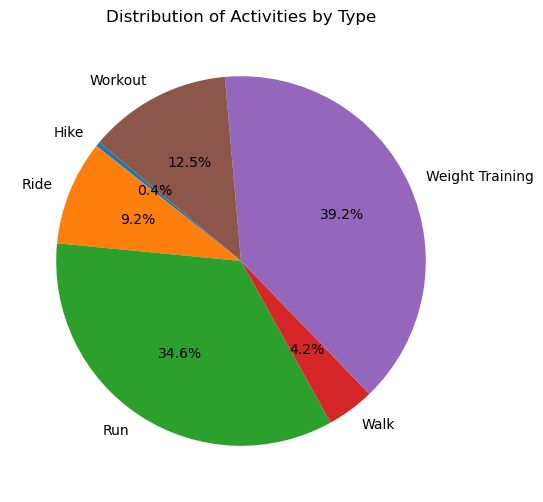

In [3]:
activities_df=pd.DataFrame(activities)
# print(activities_df[activities_df['type']=='Workout'])
activities_df['type']=activities_df['type'].replace('WeightTraining','Weight Training')
activities_df['sport_type']=activities_df['sport_type'].replace('WeightTraining','Weight Training')
activities_df['sport_type']=activities_df['sport_type'].replace('HighIntensityIntervalTraining','HIIT')
activities_by_type = activities_df.groupby('type').size()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(activities_by_type, labels=activities_by_type.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Activities by Type')
plt.show()

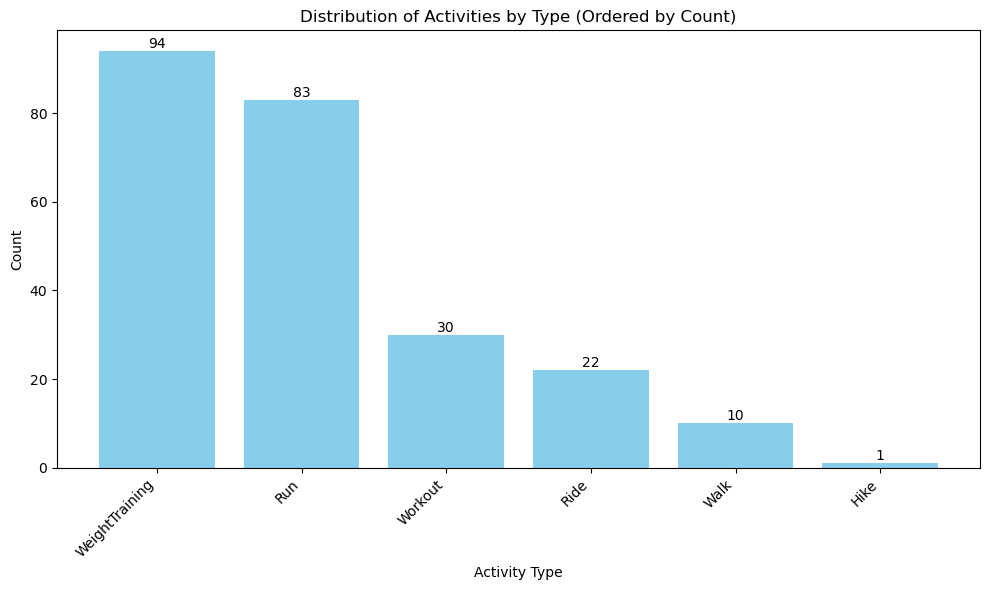

In [10]:
# Group activities by type and sort by count
activities_by_type = activities_df.groupby('type').size().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(activities_by_type.index, activities_by_type.values, color='skyblue')

# Add titles and labels
plt.title('Distribution of Activities by Type (Ordered by Count)')
plt.xlabel('Activity Type')
plt.ylabel('Count')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

# Display the bar chart
plt.tight_layout()
plt.show()


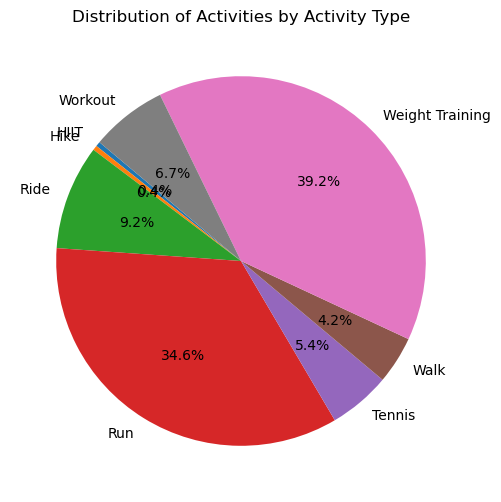

In [4]:
activities_by_sport_and_type = activities_df.groupby(['sport_type']).size()
# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(activities_by_sport_and_type, labels=activities_by_sport_and_type.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Activities by Activity Type')
plt.show()

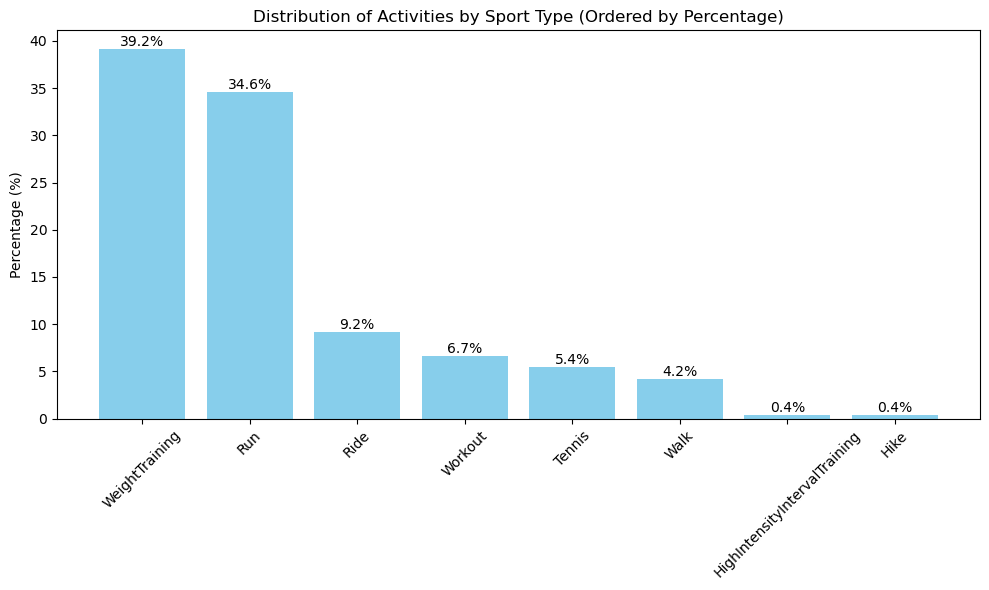

In [18]:
# Group activities by 'sport_type' and calculate the count
activities_by_sport_and_type = activities_df.groupby(['sport_type']).size()

# Calculate the percentage of each sport type
activities_percentage = (activities_by_sport_and_type / activities_by_sport_and_type.sum()) * 100

# Sort the values in descending order
activities_percentage_sorted = activities_percentage.sort_values(ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(activities_percentage_sorted.index, activities_percentage_sorted.values, color='skyblue')

# Add labels and title
plt.ylabel('Percentage (%)')
plt.title('Distribution of Activities by Sport Type (Ordered by Percentage)')
plt.xticks(rotation=45)

# Annotate each bar with its percentage value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}%', va='bottom', ha='center')

plt.tight_layout()
plt.show()

### Statistics of run activities

In [11]:
activities_df=pd.DataFrame(activities)
running_activities=activities_df[activities_df['type']=='Run']
average_bpm= round(running_activities['average_heartrate'].mean(),2)
average_distance=running_activities['distance'].mean()/1000
average_elevation=round(running_activities['total_elevation_gain'].mean(),2)
average_moving_time_minutes=round(running_activities['moving_time'].mean(),2)//60
average_moving_time_seconds=round(running_activities['moving_time'].mean(),2)%60
total_distance=running_activities['distance'].sum()/1000
total_runs=running_activities.shape[0]
# print(running_activities.columns)
print("Average heart rate: %.0f bpm.\nAverage run distance: %.2f km.\nAverage elevation gain: %.2f meters.\nAverage moving time: %.0f minutes and %.0f seconds.\nAverage running pace: %.0f:%.0f min/km.\nTotal distance: %.2f km\nTotal runs: %.0f"
      % (
        average_bpm,
        average_distance,
        average_elevation,
        average_moving_time_minutes,
        average_moving_time_seconds,
        average_moving_time_minutes//average_distance,
        (((average_moving_time_minutes+(average_moving_time_seconds/60))/average_distance)-average_moving_time_minutes//average_distance)*60,
        total_distance,
        total_runs
    ))

Average heart rate: 161 bpm.
Average run distance: 8.58 km.
Average elevation gain: 57.96 meters.
Average moving time: 50 minutes and 0 seconds.
Average running pace: 5:50 min/km.
Total distance: 712.45 km
Total runs: 83


### Run activities by month

C:\Users\Santiago\AppData\Local\Temp\ipykernel_10168\949704385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_activities['start_date']=pd.to_datetime(running_activities['start_date'])
C:\Users\Santiago\AppData\Local\Temp\ipykernel_10168\949704385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  running_activities['month']=running_activities['start_date'].dt.month
C:\Users\Santiago\AppData\Local\Temp\ipykernel_10168\949704385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

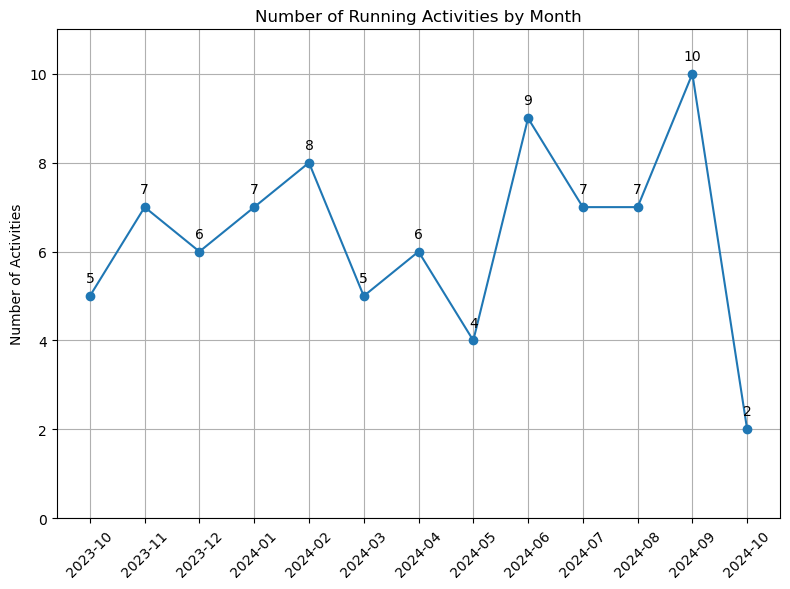

In [17]:
running_activities['start_date']=pd.to_datetime(running_activities['start_date'])
running_activities['month']=running_activities['start_date'].dt.month
running_activities['year']=running_activities['start_date'].dt.year
running_activities['year_month'] = running_activities['start_date'].dt.strftime('%Y-%m')

# Count the number of activities per YYYY-MM
activity_counts = running_activities['year_month'].value_counts().sort_index()

# Create the line chart
plt.figure(figsize=(8, 6))
plt.plot(activity_counts.index, activity_counts.values, marker='o', linestyle='-')
plt.ylabel('Number of Activities')
plt.title('Number of Running Activities by Month')
plt.xticks(rotation=45)
plt.grid(True)
# Set y-axis limits to ensure proper visualization
plt.ylim(0, max(activity_counts.values) * 1.1)  # Set upper limit 10% above the max value

plt.tight_layout()
for i, (month, count) in enumerate(activity_counts.items()):
    plt.annotate(f'{count}', (month, count), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

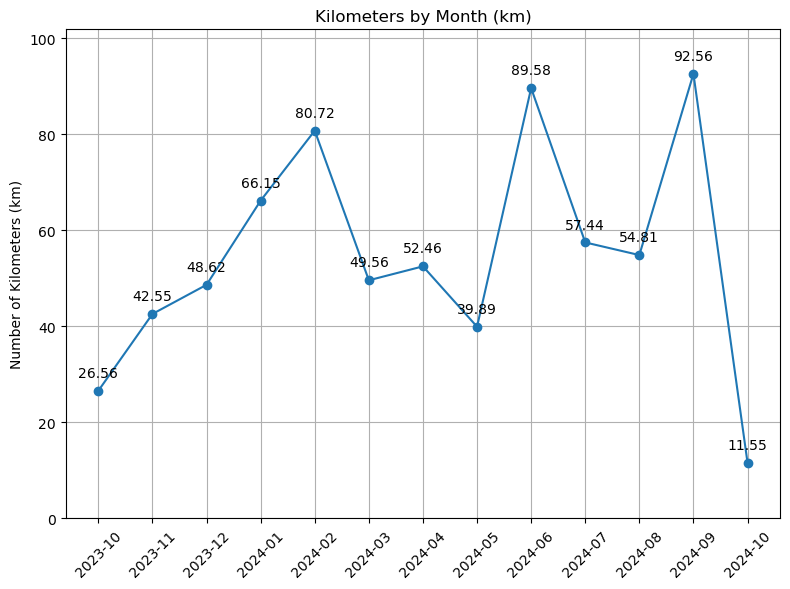

In [14]:
# Count the number of activities per YYYY-MM
monthly_distance = round(running_activities.groupby('year_month')['distance'].sum() / 1000, 2)

# Create the line chart
plt.figure(figsize=(8, 6))
plt.plot(monthly_distance.index, monthly_distance.values, marker='o', linestyle='-')

# Add labels and title
plt.ylabel('Number of Kilometers (km)')
plt.title('Kilometers by Month (km)')
plt.xticks(rotation=45)
plt.grid(True)

# Set y-axis limits to ensure proper visualization
plt.ylim(0, max(monthly_distance.values) * 1.1)  # Set upper limit 10% above the max value

# Annotate the values on the line chart
for i, (month, count) in enumerate(monthly_distance.items()):
    plt.annotate(f'{count}', (month, count), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()